# 1) Data Loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
spark = SparkSession.builder \
    .appName("myapp") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .master('local[*]') \
    .getOrCreate()

24/12/04 19:20:27 WARN Utils: Your hostname, MacBook-Air-mba.local resolves to a loopback address: 127.0.0.1; using 192.168.1.143 instead (on interface en0)
24/12/04 19:20:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/04 19:20:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50785)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/Users/savato/Data Science/ddam/ddam/lib/python3.11/s

In [3]:
# df = spark.read.csv('dataset/preprocessed_data/preprocessedData_SI.csv', header=True, inferSchema=True)
df = spark.read.csv('/Users/savato/Data Science/ddam/dataset/PreprocessedDataStringIndexed.csv/dataset_preprocessed.csv', header=True, inferSchema=True)

In [4]:
#Rename target_bool column to label
df_transformed = df.withColumnRenamed("fraud_bool", "label")

# 2) Train Test Split

In [6]:
df_transformed.show(5)

24/12/04 19:21:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-------------------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+-------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|             income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|       velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_mo

In [7]:
# split train test
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)
train_data.groupBy('label').count().show()
test_data.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|791463|
|  1.0|  8827|
+-----+------+



+-----+------+
|label| count|
+-----+------+
|  0.0|197508|
|  1.0|  2202|
+-----+------+



In [8]:
train_data.show(5)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid| bank_months_count|has_other_cards|pro

# 3) Sampling

## No technique

In [8]:
train_data_sampled = train_data
test_data_sampled = test_data

## Random Undersampling

In [19]:
# Under-sampling the majority class
majority_class = train_data.filter(train_data['label'] == 0)
minority_class = train_data.filter(train_data['label'] == 1)

# Setting the seed for reproducibility
seed = 42
# Downsample the majority class
majority_downsampled = majority_class.sample(False, minority_class.count() / majority_class.count(), seed)

# Combine the downsampled majority class with the minority class
train_data_sampled = majority_downsampled.union(minority_class)

# Show the number of fraud and non-fraud transactions
train_data_sampled.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 8888|
|  1.0| 8827|
+-----+-----+



## Random Oversampling

In [8]:
# Separate the majority and minority classes
majority_class = train_data.filter(train_data['label'] == 0)
minority_class = train_data.filter(train_data['label'] == 1)

# Calculate the ratio to oversample the minority class
ratio = majority_class.count() / minority_class.count()

print(f"Ratio: {ratio}")    

# Oversample the minority class
minority_oversampled = minority_class.sample(withReplacement=True, fraction=ratio, seed=42)

# Combine the oversampled minority class with the majority class
train_data_sampled = majority_class.union(minority_oversampled)

# Show the number of fraud and non-fraud transactions
train_data_sampled.groupBy('label').count().show()

Ratio: 89.66387221026396


+-----+------+
|label| count|
+-----+------+
|  0.0|791463|
|  1.0|791109|
+-----+------+



## Weights "sampling"

In [12]:
total_count = train_data.count()
pos_count = train_data.filter(col("label") == 1).count()
neg_count = total_count - pos_count

# Compute class weights
pos_weight = total_count / (2.0 * pos_count)
neg_weight = total_count / (2.0 * neg_count)

print(f"Positive weight: {pos_weight}")
print(f"Negative weight: {neg_weight}")

# Add the weight column to the dataset
train_data_sampled = train_data.withColumn(
    "weight", when(col("label") == 1, pos_weight).otherwise(neg_weight)
)


Positive weight: 45.33193610513198
Negative weight: 0.5055763819660553


In [9]:
train_data_sampled.show(2)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+------------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|      zip_count_4w|        velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid| bank_months_count|ha

## SMOTE

In [9]:
train_data.show(5)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+-------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|        velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid| bank_months_count|has_other_cards|pro

In [10]:
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

# 1. Converti il formato tabellare in features + label
feature_columns = [col for col in train_data.columns if col != 'label']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
train_data = vector_assembler.transform(train_data).select('features', 'label')

# Convert the Spark DataFrame to a format suitable for SMOTE
train_data_rdd = train_data.rdd.map(lambda row: (row['label'], Vectors.dense(row['features'])))

# Convert RDD to a list of tuples
train_data_list = train_data_rdd.collect()

# Separate features and labels
X_train = [row[1].toArray() for row in train_data_list]
y_train = [row[0] for row in train_data_list]

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert the resampled data back to Spark DataFrame
resampled_rdd = spark.sparkContext.parallelize([Row(label=float(y), features=Vectors.dense(x)) for x, y in zip(X_resampled, y_resampled)])
train_data_sampled = spark.createDataFrame(resampled_rdd)

# Show the distribution of label in train_data_resampled
train_data_sampled.groupBy('label').count().show()

24/12/04 19:22:38 WARN TaskSetManager: Stage 12 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:22:39 WARN TaskSetManager: Stage 13 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.


+-----+------+
|label| count|
+-----+------+
|  0.0|791463|
|  1.0|791463|
+-----+------+



In [15]:
train_data_prepared = train_data_sampled

# Define all feature columns (exclude "label")
feature_columns = [col for col in test_data.columns if col != "label"]
print(feature_columns)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
test_data_prepared = vector_assembler.transform(test_data).select("features", "label")

# show the distribution of label in train_data_prepared
test_data_prepared.groupBy('label').count().show()

['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'month_encoded', 'payment_type_encoded', 'employment_status_encoded', 'housing_status_encoded', 'source_encoded', 'device_os_encoded']


+-----+------+
|label| count|
+-----+------+
|  0.0|197508|
|  1.0|  2202|
+-----+------+



# 4) Prepare data (trasform to features+label)

In [9]:
train_data_sampled.show(5)

24/12/04 19:19:06 WARN TaskSetManager: Stage 15 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.0,8.7849166548...|
|  0.0|[0.0,1.0062007118...|
|  0.0|[0.0,1.9547219925...|
|  0.0|[0.0,3.5509493560...|
|  0.0|[0.0,4.1789765739...|
+-----+--------------------+
only showing top 5 rows



24/12/04 19:19:10 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 15 (TID 47): Attempting to kill Python Worker


In [10]:
test_data.show(2)

+-----+------+---------------------+-------------------------+----------------------------+------------+--------------------+----------------------+-------------------+------------------+------------------+------------------+--------------------+--------------------------------+-------------------+-------------+----------------+------------------+-------------------+---------------+---------------------+---------------+-------------------------+------------------+-------------------------+-------------+--------------------+-------------------------+----------------------+--------------+-----------------+
|label|income|name_email_similarity|prev_address_months_count|current_address_months_count|customer_age|  days_since_request|intended_balcon_amount|       zip_count_4w|       velocity_6h|      velocity_24h|       velocity_4w|bank_branch_count_8w|date_of_birth_distinct_emails_4w|  credit_risk_score|email_is_free|phone_home_valid|phone_mobile_valid|  bank_months_count|has_other_cards|pro

In [11]:
from pyspark.ml.feature import VectorAssembler

# Define all feature columns (exclude "label")
feature_columns = [col for col in train_data_sampled.columns if col not in ["label", "weight"]]
print(feature_columns)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply the transformation to both train and test data
train_data_prepared = vector_assembler.transform(train_data_sampled).select("features", "label")

# Define all feature columns (exclude "label")
feature_columns = [col for col in test_data.columns if col != "label"]
print(feature_columns)

# Combine features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
test_data_prepared = vector_assembler.transform(test_data).select("features", "label")

# show the distribution of label in train_data_prepared
train_data_prepared.groupBy('label').count().show()

['features']


IllegalArgumentException: Output column features already exists.

In [ ]:
train_data_prepared.select('features').show(5, truncate=False)
train_data_prepared.show(2)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------+-----+------------------+
|            features|label|            weight|
+--------------------+-----+------------------+
|[0.0,8.7849166548...|  0.0|0.5055763819660553|
|[0.0,1.0062007118...|  0.0|0.5055763819660553|
+--------------------+-----+------------------+
only showing top 2 rows



In [ ]:
test_data_prepared.select('features').show(5, truncate=False)
test_data_prepared.show(2)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,1.3371449303...|  0.0|
|[0.0,4.2384881753...|  0.0|
+--------------------+-----+
only showing top 2 rows



# Dummy model

(always predict majority class)

In [43]:
from pyspark.sql import functions as F

# calculate majority class
majority_class = train_data_prepared.groupBy('label').count().orderBy('count', ascending=False).first()[0]
print(f"Majority class: {majority_class}")

# add column prediction with majority class
predictions = test_data_prepared.withColumn("prediction", F.lit(majority_class))

# add column rawPrediction with Double value 1.0
predictions = predictions.withColumn("rawPrediction", F.lit(1.0))

predictions.show(5)

Majority class: 0.0


+--------------------+-----+----------+-------------+
|            features|label|prediction|rawPrediction|
+--------------------+-----+----------+-------------+
|[0.0,1.3371449303...|  0.0|       0.0|          1.0|
|[0.0,4.2384881753...|  0.0|       0.0|          1.0|
|[0.0,9.5322385080...|  0.0|       0.0|          1.0|
|[0.0,0.0018702182...|  0.0|       0.0|          1.0|
|[0.0,0.0024724864...|  0.0|       0.0|          1.0|
+--------------------+-----+----------+-------------+
only showing top 5 rows



# RandomForest

## Grid Search

In [ ]:
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# from pyspark.ml.classification import RandomForestClassifier
# rf = RandomForestClassifier(featuresCol="features", labelCol="label")


# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [150, 200, 250]) \
#     .addGrid(rf.maxDepth, [10, 15]) \
#     .addGrid(rf.minInstancesPerNode, [2, 5]) \
#     .build()

# cv = CrossValidator(estimator=rf, 
#                     estimatorParamMaps=paramGrid, 
#                     evaluator=BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC"), 
#                     numFolds=2)

# cvModel = cv.fit(train_data_sampled)

In [ ]:
# # Recupera il modello migliore
# best_model = cvModel.bestModel

# # Ottieni i parametri migliori
# num_trees = best_model.getNumTrees
# max_depth = best_model.getMaxDepth()
# min_instances_per_node = best_model.getMinInstancesPerNode()

# # Stampa i valori
# print("Best Parameters:")
# print(f" - numTrees: {num_trees}")
# print(f" - maxDepth: {max_depth}")
# print(f" - minInstancesPerNode: {min_instances_per_node}")

Best Parameters:
 - numTrees: 150
 - maxDepth: 10
 - minInstancesPerNode: 1


## Best params (my pc cannot go further)

In [17]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Step 1: Define the Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=150, maxDepth=10, \
    # weightCol="weight"\
        )

# Step 2: Train the Model on Train Data
rf_model = rf.fit(train_data_prepared)

# Step 3: Make Predictions on Test Data
predictions = rf_model.transform(test_data_prepared)

24/12/04 19:32:06 WARN TaskSetManager: Stage 21 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:32:33 WARN TaskSetManager: Stage 24 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:32:37 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 24 (TID 68): Attempting to kill Python Worker
24/12/04 19:32:37 WARN TaskSetManager: Stage 25 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:32:50 WARN TaskSetManager: Stage 26 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:33:13 WARN TaskSetManager: Stage 28 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/04 19:33:54 WARN TaskSetManager: Stage 30 contains a task of very large size (52918 KiB). The maximum recommended task size is 1000 KiB.
24/12/

Py4JJavaError: An error occurred while calling o337.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 42.0 failed 1 times, most recent failure: Lost task 3.0 in stage 42.0 (TID 208) (192.168.1.143 executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22(RandomForest.scala:651)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22$adapted(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$4803/0x000000080218f678.apply(Unknown Source)
	at scala.Array$.tabulate(Array.scala:418)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$4762/0x0000000802177520.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$2989/0x0000000801e43350.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2741/0x0000000801db3cb8.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.runWith(Thread.java:1636)
	at java.base/java.lang.Thread.run(Thread.java:1623)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2458)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$collectAsMap$1(PairRDDFunctions.scala:738)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.PairRDDFunctions.collectAsMap(PairRDDFunctions.scala:737)
	at org.apache.spark.ml.tree.impl.RandomForest$.findBestSplits(RandomForest.scala:663)
	at org.apache.spark.ml.tree.impl.RandomForest$.runBagged(RandomForest.scala:208)
	at org.apache.spark.ml.tree.impl.RandomForest$.run(RandomForest.scala:302)
	at org.apache.spark.ml.classification.RandomForestClassifier.$anonfun$train$1(RandomForestClassifier.scala:168)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:139)
	at org.apache.spark.ml.classification.RandomForestClassifier.train(RandomForestClassifier.scala:47)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.tree.impl.DTStatsAggregator.<init>(DTStatsAggregator.scala:77)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22(RandomForest.scala:651)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$22$adapted(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$4803/0x000000080218f678.apply(Unknown Source)
	at scala.Array$.tabulate(Array.scala:418)
	at org.apache.spark.ml.tree.impl.RandomForest$.$anonfun$findBestSplits$21(RandomForest.scala:647)
	at org.apache.spark.ml.tree.impl.RandomForest$$$Lambda$4762/0x0000000802177520.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$2989/0x0000000801e43350.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2741/0x0000000801db3cb8.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.runWith(Thread.java:1636)
	... 1 more


# Confusion Matrix, Precision, Recall, F1, AUC

### versione nuova

In [25]:
print(type(predictions))
predictions.show(5)

<class 'pyspark.sql.dataframe.DataFrame'>


24/12/04 19:06:34 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.0,1.3371449303...|  0.0|[116.436423055140...|[0.77624282036760...|       0.0|
|[0.0,4.2384881753...|  0.0|[132.185834728776...|[0.88123889819184...|       0.0|
|[0.0,9.5322385080...|  0.0|[105.876656665612...|[0.70584437777074...|       0.0|
|[0.0,0.0018702182...|  0.0|[125.280535969204...|[0.83520357312802...|       0.0|
|[0.0,0.0024724864...|  0.0|[104.052133577898...|[0.69368089051932...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



24/12/04 19:06:42 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
24/12/04 19:07:01 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
24/12/04 19:07:03 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB



Metrics:
Class 0 (False): Precision = 1.00, Recall = 0.86, F1-Score = 0.92
Class 1 (True):  Precision = 0.05, Recall = 0.70, F1-Score = 0.10
AUC: 0.8737


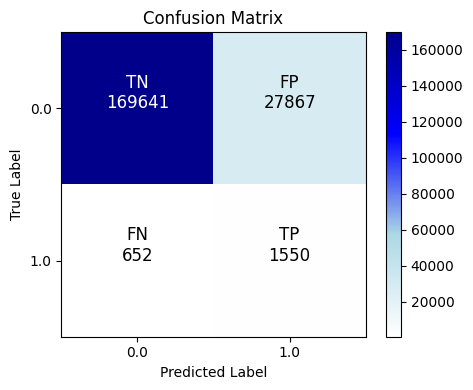

In [26]:
from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Step 1: Create a full confusion matrix
labels = [0.0, 1.0]
predictions_full = (
    predictions.groupBy("label", "prediction")
    .count()
    .withColumnRenamed("count", "actual_count")
)

# Add missing combinations with a count of 0
from pyspark.sql import Row
all_combinations = [
    Row(label=float(lbl), prediction=float(pred)) for lbl in labels for pred in labels
]
all_combinations_df = spark.createDataFrame(all_combinations)
confusion_matrix_full = (
    all_combinations_df.join(
        predictions_full, ["label", "prediction"], "left_outer"
    )
    .fillna(0, subset=["actual_count"])
)

# Convert to Pandas for visualization
confusion_matrix_pd = confusion_matrix_full.toPandas()

# Create confusion matrix array
confusion_matrix_array = np.zeros((len(labels), len(labels)))
for _, row in confusion_matrix_pd.iterrows():
    i = labels.index(row["label"])
    j = labels.index(row["prediction"])
    confusion_matrix_array[i, j] = row["actual_count"]

# Step 2: Extract TP, FP, FN, TN
tp = confusion_matrix_array[1, 1]  # True Positives
fp = confusion_matrix_array[0, 1]  # False Positives
fn = confusion_matrix_array[1, 0]  # False Negatives
tn = confusion_matrix_array[0, 0]  # True Negatives

# Step 3: Calculate Metrics
precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

# Calculate AUC
auc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = auc_evaluator.evaluate(predictions)

# Step 4: Display Metrics
print("\nMetrics:")
print(f"Class 0 (False): Precision = {precision_0:.2f}, Recall = {recall_0:.2f}, F1-Score = {f1_0:.2f}")
print(f"Class 1 (True):  Precision = {precision_1:.2f}, Recall = {recall_1:.2f}, F1-Score = {f1_1:.2f}")
print(f"AUC: {auc:.4f}")

# Step 5: Plot Confusion Matrix with Annotations
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["white", "lightblue", "blue", "darkblue"]
)

plt.figure(figsize=(5, 4))
plt.imshow(confusion_matrix_array, interpolation="nearest", cmap=custom_cmap)
plt.title("Confusion Matrix")
plt.colorbar()

# Label the axes
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# Add counts and acronyms in each cell
annotations = [["TN", "FP"], ["FN", "TP"]]
thresh = confusion_matrix_array.max() / 2.0
for i in range(len(labels)):
    for j in range(len(labels)):
        count = int(confusion_matrix_array[i, j])
        label = annotations[i][j]
        plt.text(
            j,
            i,
            f"{label}\n{count}",
            horizontalalignment="center",
            color="white" if confusion_matrix_array[i, j] > thresh else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()


### versione vecchia

In [ ]:
# from pyspark.sql import functions as F
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# # Step 1: Distribution of the Target Variable
# target_distribution = predictions.groupBy("label").count().collect()
# for row in target_distribution:
#     print(f"Class {int(row['label'])} Count: {row['count']}")

# # Step 2: Confusion Matrix
# confusion_matrix = predictions.groupBy("label", "prediction").count()
# confusion_matrix.show()

# # Extract TP, FP, FN, TN safely
# tp_row = confusion_matrix.filter((F.col("label") == 1) & (F.col("prediction") == 1)).select(F.col("count")).first()
# tp = tp_row[0] if tp_row else 0

# fp_row = confusion_matrix.filter((F.col("label") == 0) & (F.col("prediction") == 1)).select(F.col("count")).first()
# fp = fp_row[0] if fp_row else 0

# fn_row = confusion_matrix.filter((F.col("label") == 1) & (F.col("prediction") == 0)).select(F.col("count")).first()
# fn = fn_row[0] if fn_row else 0

# tn_row = confusion_matrix.filter((F.col("label") == 0) & (F.col("prediction") == 0)).select(F.col("count")).first()
# tn = tn_row[0] if tn_row else 0

# # Step 3: Metrics Calculation for Each Class
# # Precision
# precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
# precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0

# # Recall
# recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
# recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0

# # F1-Score
# f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0
# f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

# # Step 4: AUC Calculation
# auc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
# auc = auc_evaluator.evaluate(predictions)

# # Step 5: Display Metrics
# print("\nMetrics:")
# print(f"Class 0 (False): Precision = {precision_0:.2f}, Recall = {recall_0:.2f}, F1-Score = {f1_0:.2f}")
# print(f"Class 1 (True):  Precision = {precision_1:.2f}, Recall = {recall_1:.2f}, F1-Score = {f1_1:.2f}")
# print(f"AUC: {auc:.4f}")

Class 0 Count: 197508
Class 1 Count: 2202


+-----+----------+------+
|label|prediction| count|
+-----+----------+------+
|  0.0|       0.0|197508|
|  1.0|       0.0|  2202|
+-----+----------+------+




Metrics:
Class 0 (False): Precision = 0.99, Recall = 1.00, F1-Score = 0.99
Class 1 (True):  Precision = 0.00, Recall = 0.00, F1-Score = 0.00
AUC: 0.5000


# XAI

## Feature importance of the model with random undersampling

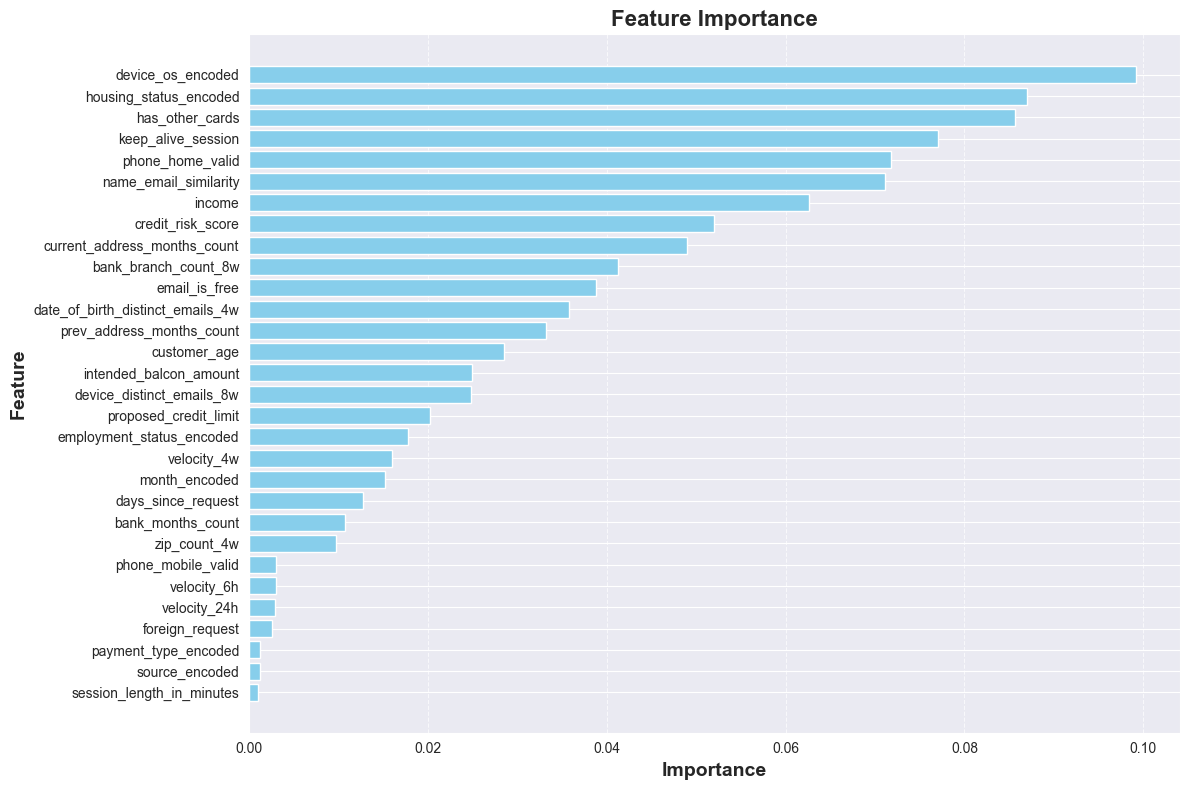

In [106]:
# Features importance
feature_importance_undersampling = model_undersampling.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_undersampling[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Feature importance of the model with weights

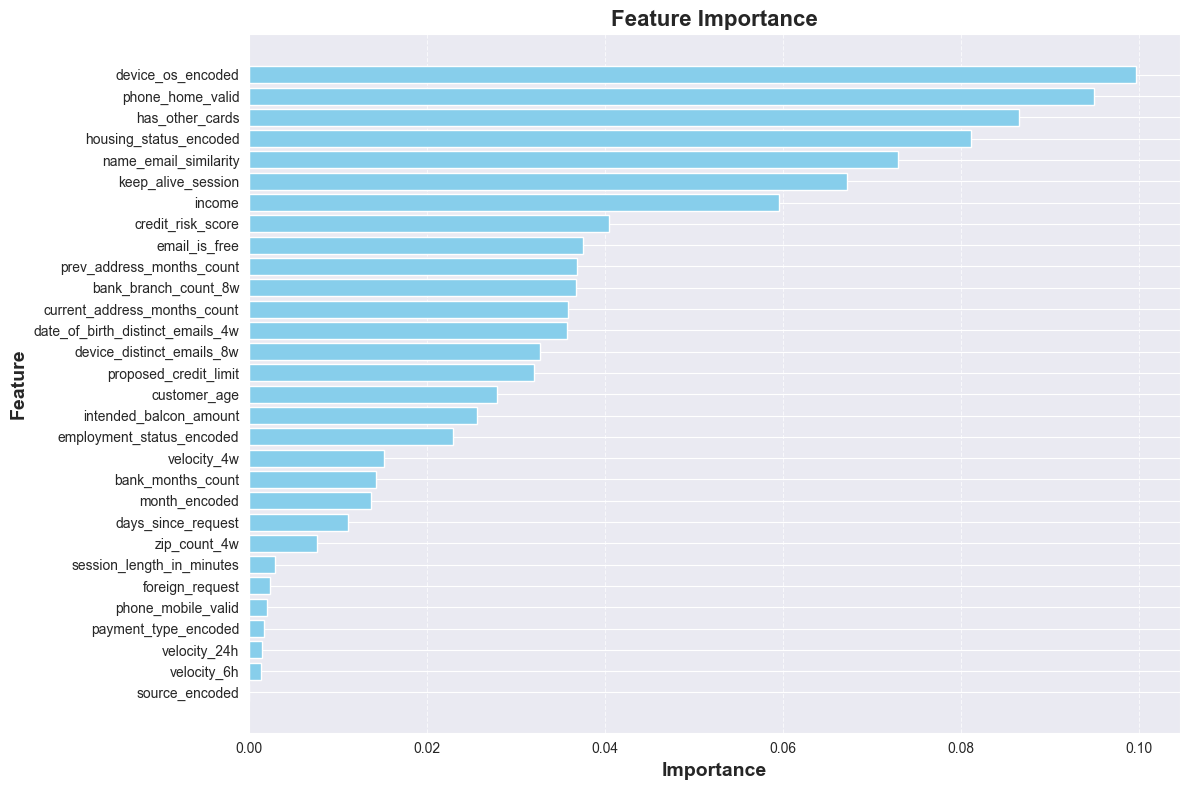

In [107]:
feature_importance_weighted = model_withWeights.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_weighted[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Feature importance of the baseline model

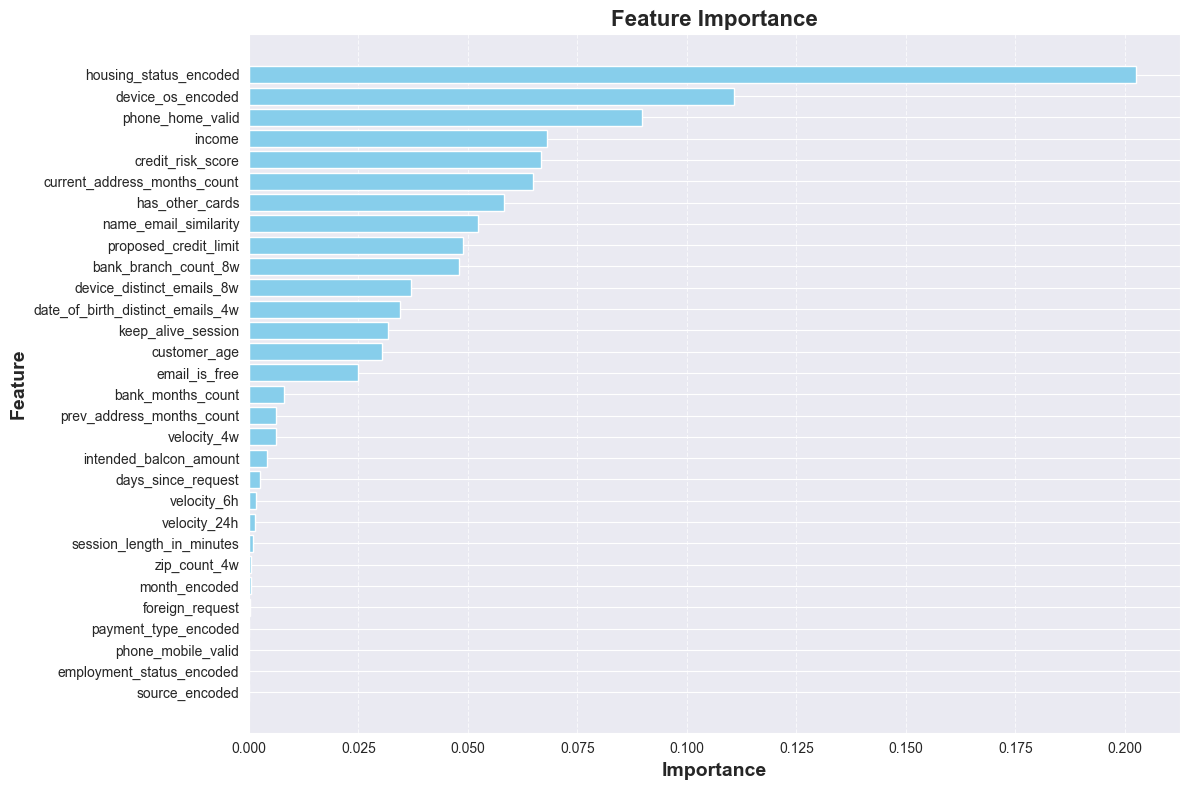

In [108]:
feature_importance_baseline = baseline_model.featureImportances

# Combine features and their importance into a list of tuples
feature_importance_tuples = [(feature, feature_importance_baseline[i]) for i, feature in enumerate(columns)]

# Sort the tuples by importance in descending order
sorted_feature_importance = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Separate the sorted features and their importance values
sorted_features, sorted_importance = zip(*sorted_feature_importance)

# Plot the sorted feature importance
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importance, color="skyblue")
plt.xlabel("Importance", fontsize=14, weight="bold")
plt.ylabel("Feature", fontsize=14, weight="bold")
plt.title("Feature Importance", fontsize=16, weight="bold")

# Add grid for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Reverse the order of y-axis labels for better visualization
plt.gca().invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# SHAP

In [110]:
import shap

In [109]:
subset = df_transformed.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

In [113]:
explainer = shap.TreeExplainer(model_undersampling)
shap_values = explainer.shap_values(subset.drop(columns=["label"]), check_additivity=False)

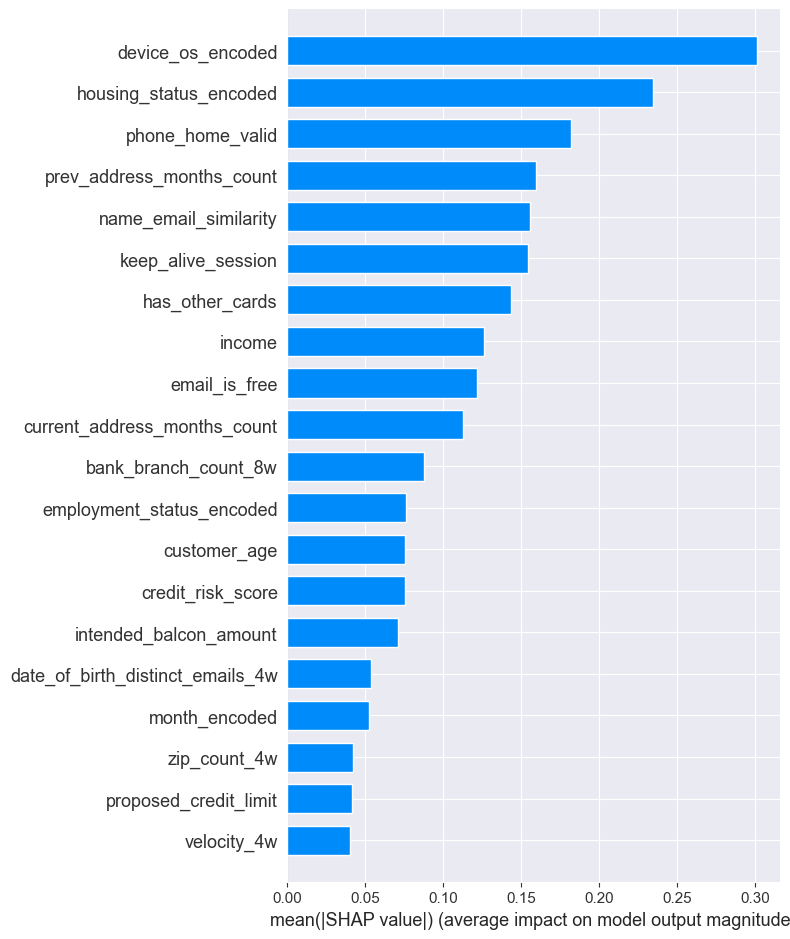

In [114]:
shap.summary_plot(shap_values, subset.drop(columns=["label"]), plot_type="bar")